In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans, MiniBatchKMeans

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
variables_cluster = [
        'prods_cant',
        'hb_flag',
        'ope_tipo_operacion_SUELDO',
        'desc_segmento_PREVISIONAL',
        'pza_flag',       
        'ctas_saldo_ars',
        'ctas_cred_total_ars',
        'inv_capital_ars',
        'txe_cant',
        'ctc_cant',
        'txe_ctc_monto_ars',
        'prestamos_personales_capintc',
]

df = pd.read_csv('1906.csv', sep='|', decimal=',', usecols=variables_cluster)

In [3]:
### Normalizacion y reconvercion de tipos de datos ###
### Normalizacion y reconvercion de tipos de datos ###


def z_transform(tabla, variables):
    for col in variables:
        tabla[col] = tabla[col].astype(float) 
        tabla[col].values[tabla[col] <= 0] = np.NaN  
        tabla[col] = tabla[col].apply(np.log)  
        tabla[col] = (tabla[col] - tabla[col].mean()) / tabla[col].std() 
        tabla[col].values[tabla[col] > 3] = 3  
        tabla[col].values[tabla[col] < -3] = -3 
        tabla[col].fillna(tabla[col].min(), inplace=True) 
        tabla[col] = (tabla[col] - tabla[col].min()) / (tabla[col].max() - tabla[col].min()) 
    return tabla

normalizar = [
        "ctas_saldo_ars",
        "ctas_cred_total_ars",
        "inv_capital_ars",
        "txe_ctc_monto_ars",
        "txe_cant",
        "ctc_cant",
        "prestamos_personales_capintc",
        ]


df = z_transform(df,normalizar)

prods_cant_map = {
        0:0.00,
        1:0.25,
        2:0.50,
        3:0.75,
        4:1.00,
        5:1.00,
        6:1.00,
    }
    
df["prods_cant"] = df["prods_cant"].map(prods_cant_map)

cols = df.columns
types = df.dtypes

for i, k in zip(cols, types):
    if k == 'int64':
        df[i] = df[i].astype('int32')
    elif k == 'float64':
        df[i] = df[i].astype('float32')
    else:
        pass

In [4]:
### Parametros del modelo ###
### Parametros del modelo ###

#km_param = KMeans(algorithm="auto", copy_x=True, init="k-means++", max_iter=300,
#				  n_clusters=8, n_init=10, n_jobs=-1, precompute_distances="auto",
#			      random_state=10, tol=0.0001, verbose=0)

km_param = MiniBatchKMeans(init="k-means++",
						   max_iter=1000,
						   n_clusters=8,
						   n_init=10,
						   random_state=10,
						   tol=0.0001,
						   verbose=0,
						   batch_size=400)

cluster = km_param.fit(df)

In [5]:
df_graph = df.iloc[:10000]

In [6]:
cluster_labels = cluster.predict(df_graph)

silhouette_avg = silhouette_score(df_graph, cluster_labels)
sample_silhouette_values = silhouette_samples(df_graph, cluster_labels)

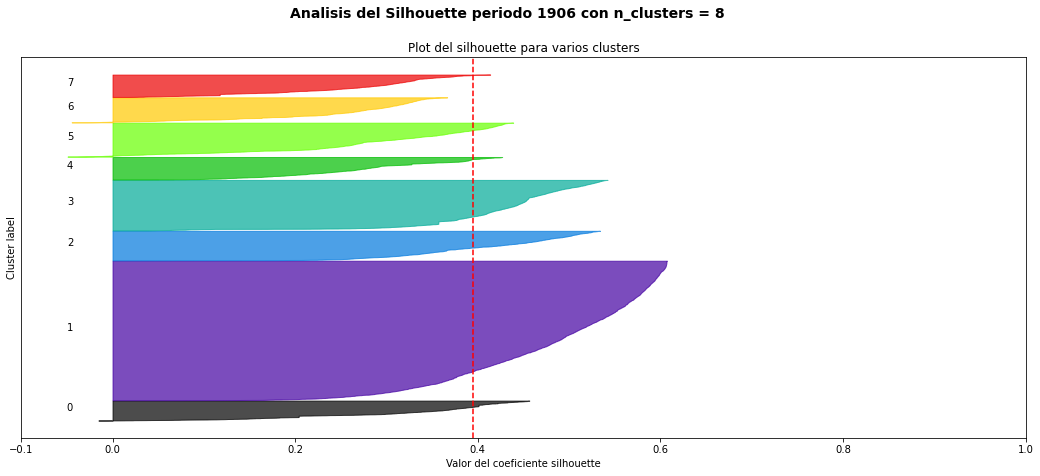

In [7]:
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

y_lower = 10

for i in range(8):
    ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / 8)
    
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
    
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10
    
ax1.set_title("Plot del silhouette para varios clusters")
ax1.set_xlabel("Valor del coeficiente silhouette")
ax1.set_ylabel("Cluster label")

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
plt.suptitle(("Analisis del Silhouette periodo 1906 "
              "con n_clusters = %d" % 8),
             fontsize=14, fontweight='bold')

plt.savefig('Silhouette1906.jpg')